In [25]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

# Carga las funciones utilitarias que hicimos.
from template_funciones import *
from template_funciones_2 import *

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [26]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

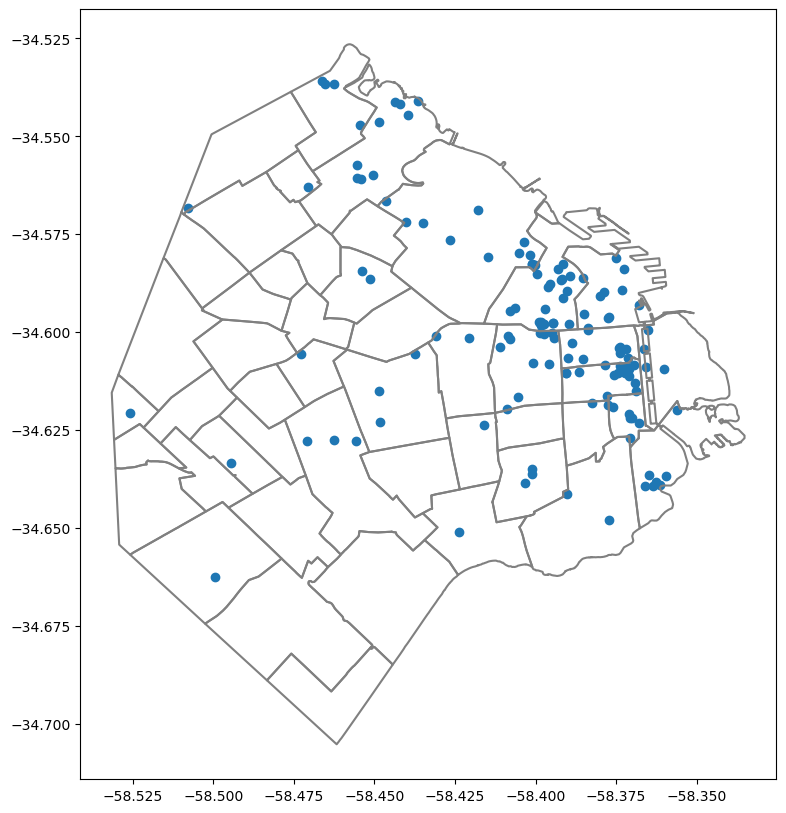

In [27]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [28]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [29]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [30]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

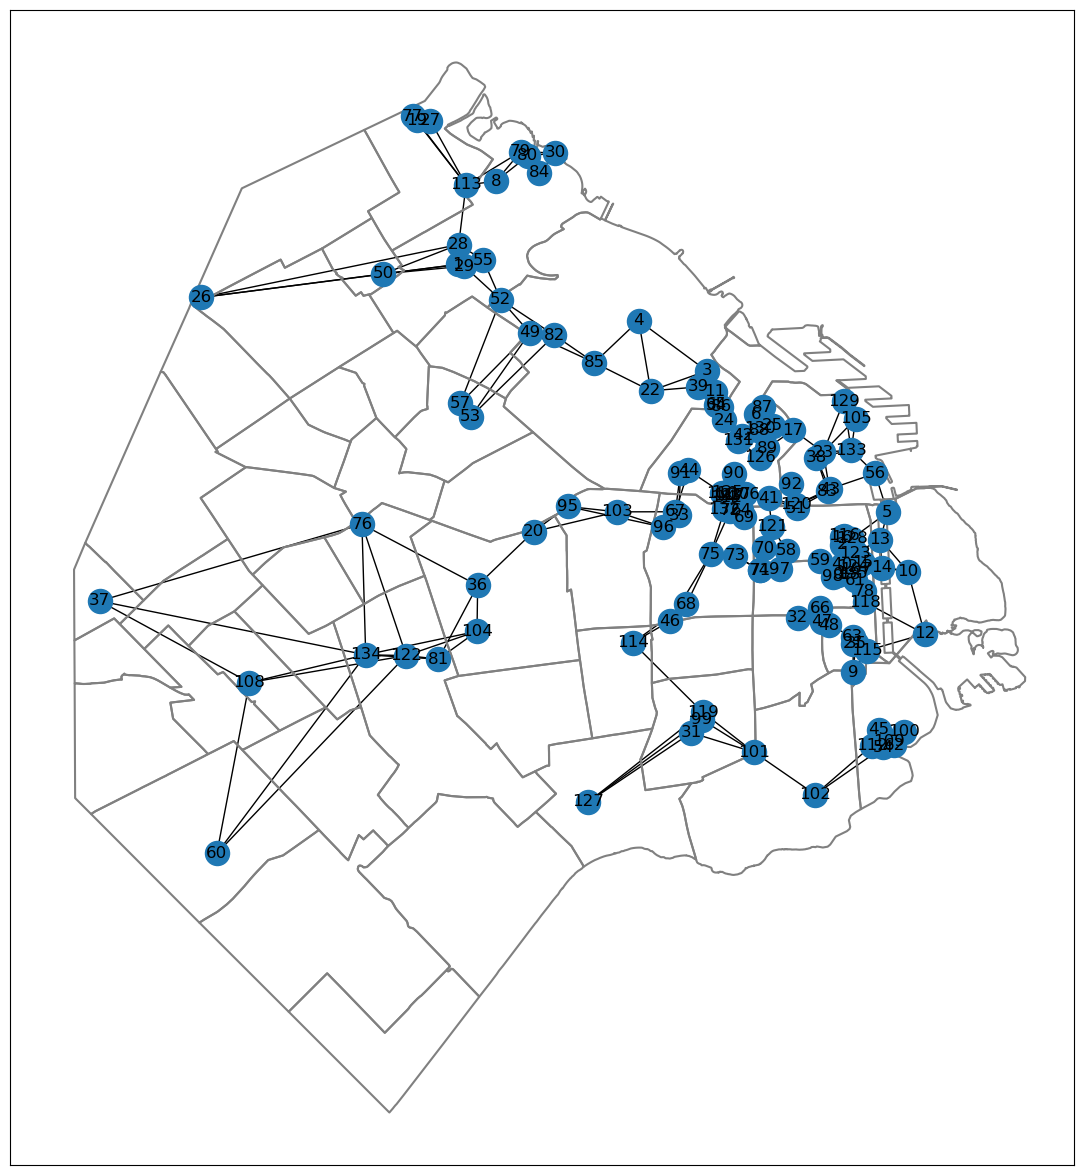

In [31]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Queremos probar que $p$ es una solución de esta ecuación.

$Mp = b$, con $M = \dfrac{N}{\alpha} (I - (1 - \alpha)C)$ y $b = 1$

La ecuación $(3)$ nos dice:
$ p = (1-\alpha)C\ p + \dfrac{\alpha}{N}1$

Partamos de dicha ecuación y lleguemos a que $Mp = b$

$p - (1 - \alpha) C\ p = \dfrac{\alpha}{N}1$

$(I - (1 - \alpha) C) p = \dfrac{\alpha}{N}1$

$\dfrac{N}{\alpha} (I - (1 - \alpha) C) p = 1$

$Mp = 1 = b$

## Punto 2:


Queremos ver cuando $Mp = b$ tiene solucion unica con:
$M = \frac{N}{\alpha} * (I- (1 - \alpha)C)$ y $b = 1$


Lo cual es equivalente a probar que $M' p = b'$ tiene solución única con $M' = (I- (1 - \alpha)C)$ y $b' = b*\dfrac{\alpha}{N}$. Notar que la primera ecuación tiene sentido porque sabemos que $\alpha \neq 0$.

Luego, $M p = b$ tiene solucion unica $\iff$ $ M' p = b'$ tiene solución única $\iff M'$ es inversible $\iff$ $Nu(M') = \{0\}$

### Proposición:
$$\alpha \in (0, 2) \Rightarrow Nu(M') = \{0\}$$

### Demostración:
Vamos a probar su reciproco:
$$Nu(M') \neq \{0\} \Rightarrow \alpha \not \in (0, 2)$$

Supongamos que el núcleo de $M'$ no es $\{0\}$, entonces existe un $\tilde{x}$ tal que $M'\tilde{x} = 0$ y $\tilde{x} \neq 0$

$(I -(1 - \alpha)C)\ \tilde{x} = 0$

$\iff$

$\tilde{x} - (1- \alpha)C \ \tilde{x} = 0$

$\iff$

$(1 - \alpha)C\  \tilde{x} = \tilde{x}$

**Entonces** si se cumple la igualdad, puedo tomar norma a ambos lados (notar que en este paso se pierde la cadena de sii).
$\space$

$\|(1 - \alpha)C\  \tilde{x}\|_1 = \|\tilde{x}\|_1$

$\space$

Como $\|\cdot\|_1$ es una norma inducida, cumple: $\|M x\|_1 \leq \|M\|_1\|x\|_1 $.

$\space$

$\|\tilde{x}\|_1 = \|(1 - \alpha)C\  \tilde{x}\|_1 \leq \|(1 - \alpha)C\|_1\| \tilde{x}\|_1$

$ \|\tilde{x}\|_1 \leq \|(1 - \alpha)C\|_1\| \tilde{x}\|_1$

$\space$

(Como $\tilde{x} \neq 0$, entonces $\|\tilde{x}\|$ $\neq$ 0 para toda norma, en particular para la norma 1. Puedo dividir a ambos lados por $\|\tilde{x}\|_1$.

$\space$

$1 \leq \|(1-\alpha)C\|_1 = |1-\alpha| \ \|C\|_1$

$\space$

Luego, como $C$ es estocástica, todas sus columnas suman 1, luego por teorema de la norma matricial 1 (máximo de la suma de sus columnas), $\|C\|_1 = 1$.

$$\|C\|_1 = \max_{1 \leq j \leq n} \{ \sum_{i=1}^{n} |a_{ij}| \} = \max_{1 \leq j \leq n} \{ 1 \} = 1$$

Luego

$1 \leq |1-\alpha|\ \iff \alpha \not \in (0, 2)$

Si existe algún $\tilde{x} \neq 0$ que cumple la ecuación $M'\tilde{x} = 0$, entonces $\alpha$ NO debe estar en $(0, 2)$.

Luego tenemos que $Nu(M') \neq \{0\} ⟹ \alpha \not \in (0, 2)$

Por lo tanto, probamos que
$\alpha \in (0, 2) \Longrightarrow Nu(M') = \{0\}$
como queríamos ver.

$\space$

Luego queda demostrado que $\alpha \in (0, 2) \Rightarrow Mp = b$ tiene única solución.

Y en particular, si $\alpha \in (0, 1) ⊆ (0,2) \Rightarrow Mp = b$ tiene única solución.

## Punto 3:

### Definamos algúnas funciones auxiliares para poder visualizar la red y sus cambios.

In [32]:
def graficarRedPesandoPageRankCatedra(D, m_mas_cercanos: int, alfa: float):
    # Grafica la red de museos asignando un tamaño a cada nodo proporcional a su Page Rank: Considerando como parametro
    # la matriz D, m_mas_cercanos y alfa.

    # Función inspirada por la dada a la catedra. Para la versión que incluye transparencias mirar graficarRedPesandoPageRankNuestro.
    
    # D: Matriz de distancias.
    # m_mas_cercanos: Parametro para armar la matriz de adyacencia.
    # Alfa: Coeficientes de damping. (0 < Alfa < 1)
    A = construye_adyacencia(D, m_mas_cercanos)  # Matriz de adyancencia que une cada museo con los m más cercanos
    pageranks = calcula_pagerank(A, alfa)  # Vector de page rank.

    ##
    # Construir el grafo
    G = nx.from_numpy_array(A)
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
    ##

    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    pr = pageranks # Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr = pr/pr.sum() # Normalizamos para que sume 1
    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

    ax.set_title(f"Museos de Buenos Aires según PageRank\n(m = {m_mas_cercanos}, alfa = {alfa})", fontsize=14)

    plt.show()

    print("Los museos principales son:")
    for i in principales:
        print(museos['name'][i])
    print("")
    

In [33]:
def graficarRedPesandoPageRankNuestro(D, m_mas_cercanos: int, alfa: float):
    # Esta función hace un gráfico similar al dibujar de la catedra pero le cambia algunos colores para que se vea mejor (opcional usarla)
    
    # Grafica la red de museos asignando un tamaño a cada nodo proporcional a su Page Rank: Considerando como parametro
    # la matriz D, m_mas_cercanos y alfa.
    
    # D: Matriz de distancias.
    # m_mas_cercanos: Parametro para armar la matriz de adyacencia.
    # Alfa: Coeficientes de damping. (0 < Alfa < 1)

    A = construye_adyacencia(D, m_mas_cercanos)  # Matriz de adyancencia que une cada museo con los m más cercanos
    pageranks = calcula_pagerank(A, alfa)  # Vector de page rank.

    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles

    # Construir el grafo
    G = nx.from_numpy_array(A)
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    fig, ax = plt.subplots(figsize=(10, 10))  # Visualización de la red en el mapa

    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)  # Graficamos Los barrios

    pageranks = pageranks/pageranks.sum()  # Normalizamos para que sume 1
    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(pageranks)[-Nprincipales:] # Identificamos a los N principales

    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos principales.
    node_colors = ['blue' if i in principales else 'red' for i in G.nodes]  # Color personalizado para los nodos principales.

    # Dibujar la red sobre el mapa
    nx.draw_networkx_edges(G, G_layout, ax=ax, edge_color='blue', alpha=0.4, width=0.7)
    nx.draw_networkx_nodes(G, G_layout, ax=ax,
                           node_size=pageranks * factor_escala,  # Escalado del tamaño por PageRank
                           node_color=node_colors,
                           edgecolors='black',
                           alpha=0.4)
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k")  # Agregamos los nombres


    ax.set_title(f"Museos de Buenos Aires según PageRank\n(m = {m_mas_cercanos}, alfa = {alfa})", fontsize=14)
    #ax.set_axis_off()
    plt.show()

    print("Los museos principales son:")
    for i in principales:
        print(museos['name'][i])
    print("")


In [ ]:
def graficarRedPesandoPageRank(D, m_mas_cercanos: int, alfa: float, usarVersionCatedra:bool = True):
    # Grafica la red de museos asignando un tamaño a cada nodo proporcional a su Page Rank: Considerando como parametro
    # la matriz D, m_mas_cercanos y alfa.
    
    # D: Matriz de distancias.
    # m_mas_cercanos: Parametro para armar la matriz de adyacencia.
    # Alfa: Coeficientes de damping. (0 < Alfa < 1)
    # usarVersionCatedra decide cual de las dos versiones usar, por defecto es graficarRedPesandoPageRankCatedra.

    if usarVersionCatedra:
        graficarRedPesandoPageRankCatedra(D, m_mas_cercanos, alfa)
    else:
        graficarRedPesandoPageRankNuestro(D, m_mas_cercanos,alfa)
    

In [35]:
def principalesAlphaFijo(D, lista_m, alpha):
  # Esta función va a calcular el pagerank de todos los museos dado un alfa fijo para distintos m. Vamos a hablar siempre de los pageranks en función de m ya que el alfa va a ser el mismo en todos los casos
  # Va a graficar como varia el pagerank de los museos que fueron principales (al menos una vez) en función del alfa
  n = D.shape[0] # Cantidad de museos
  pagerank = [[0 for _ in range(n)] for _ in range(n)] # Dado el índice i de un museo y un m, pagerank[i][m] nos dice su pagerank
  fuePrincipal = [False for _ in range(n)] # Dado el indice i de un museo, fuePrincipal[i] nos dice si fue principal alguna vez (basta con que haya un solo m que lo haga principal)

  fig, ax = plt.subplots(figsize=(10, 10))

  # Calculamos los pageranks de los museos para todos los m
  for m in lista_m:
    A = construye_adyacencia(D, m)
    pagerank_actual = calcula_pagerank(A, alpha) # El pagerank para este m

    for i in range(n):
      pagerank[i][m] = pagerank_actual[i]

    museos_ordenados = []
    for i in range(len(pagerank_actual)):
      museos_ordenados.append((pagerank_actual[i], i))
    museos_ordenados.sort() # Ordenamos los museos en base a su pagerank, su segunda coordenada nos da su indice

    for j in range(3): # Marcamos a los tres mejores museos del pagerank actual
      fuePrincipal[museos_ordenados[n-1-j][1]] = True

  # Hacemos el gráfico de cada museo que fue principal alguna vez
  for i in range(n):
    if (fuePrincipal[i]):
      pagerank_museo_i = []
      for m in lista_m:
        pagerank_museo_i.append(pagerank[i][m])

      plt.plot(lista_m, pagerank_museo_i, label=f"{museos['name'][i]}")

  ax.set_xlabel("m [Cantidad de vecinos]")
  ax.set_ylabel("Pagerank")
  ax.set_title(f"Museos principales de Buenos Aires con alfa fijo: {alpha}")

  plt.legend()
  plt.show()


In [36]:
def principalesMFijo(D, lista_alpha, m):
  # Esta función va a calcular el pagerank de todos los museos dado un m fijo para distintos alfa. Vamos a hablar siempre de los pageranks en función de alfa ya que el m va a ser el mismo en todos los casos
  # Va a graficar como varia el pagerank de los museos que fueron principales (al menos una vez) en función del m
  n = D.shape[0] # Cantidad de vecinos
  pagerank = dict() # Dado un indice i de un museo y un alfa, pagerank[i][alfa] te va a decir el pagerank del museo i
  fuePrincipal = [False for _ in range(n)] # Dado el indice i de un museo, fuePrincipal[i] nos dice si fue principal alguna vez (basta con que haya un solo alfa que lo haga principal)

  fig, ax = plt.subplots(figsize=(10, 10))
  A = construye_adyacencia(D, m)

  for i in range(n):
    pagerank[i] = dict() # Vamos a usar un diccionario para poder indexar con alfa ya que no es un entero

  for alpha in lista_alpha:
    pagerank_actual = calcula_pagerank(A, alpha) # El pagerank de los museos para este alfa

    for i in range(n):
      pagerank[i][alpha] = pagerank_actual[i]

    museos_ordenados = []
    for i in range(len(pagerank_actual)):
      museos_ordenados.append((pagerank_actual[i], i))
    museos_ordenados.sort() # Ordenamos los museos en base a su pagerank, su segunda coordenada nos da su indice

    for j in range(3): # Marcamos a los tres mejores museos del pagerank actual
      fuePrincipal[museos_ordenados[n-1-j][1]] = True

  # Hacemos el gráfico de cada museo que fue principal alguna vez
  for i in range(n):
    if (fuePrincipal[i]):
      pagerank_museo_i = []
      for v in pagerank[i].values():
        pagerank_museo_i.append(v)

      plt.plot(lista_alpha, pagerank_museo_i, label=f"Museo {museos['name'][i]}")

  ax.set_xlabel("Alfa")
  ax.set_ylabel("Pagerank")
  ax.set_title(f"Museos principales de Buenos Aires con m fijo: {m}")

  plt.legend()
  plt.show()



### Visualicemos la red.

Visualicemos la red de conectando a cada museo con sus m=3 vecinos más cercanos y calculando su Page Rank considerando alfa = 1/5, donde el tamaño de los nodos (museos) es proporcional al Page Rank que le toca.

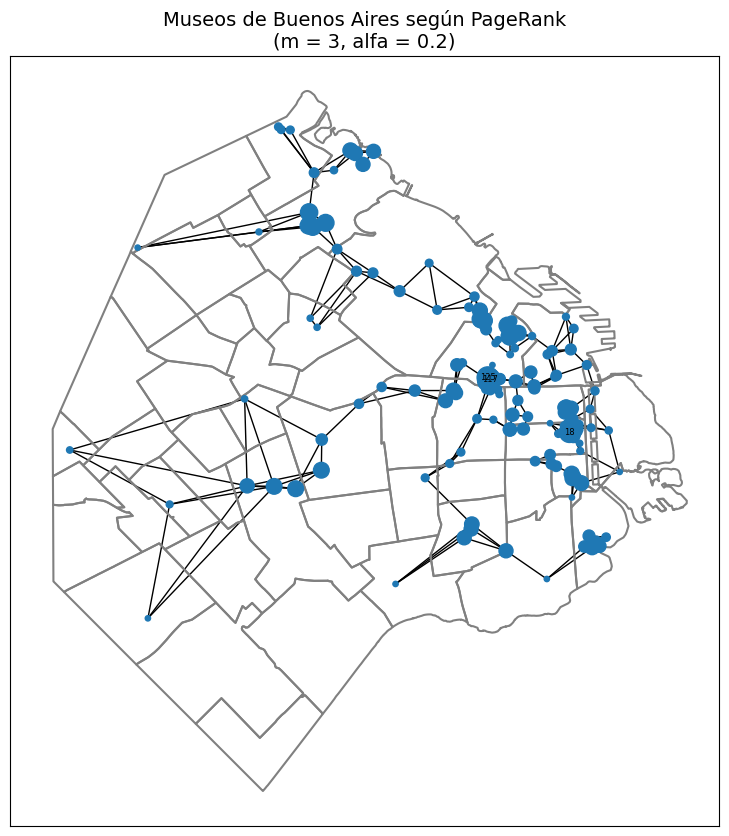

Los museos principales son:
Museo de la Ciudad
Museo de la Facultad de Odontología
Museo de Farmacobotánica



In [37]:
graficarRedPesandoPageRank(D, 3, 1/5)

### Observemos que sucede si dejamos el alfa fijo en 1/5, y vamos modificando el m.

Miremos como va cambiando la red de museos y van cambiando sus PageRank a medida que cambiamos el m.

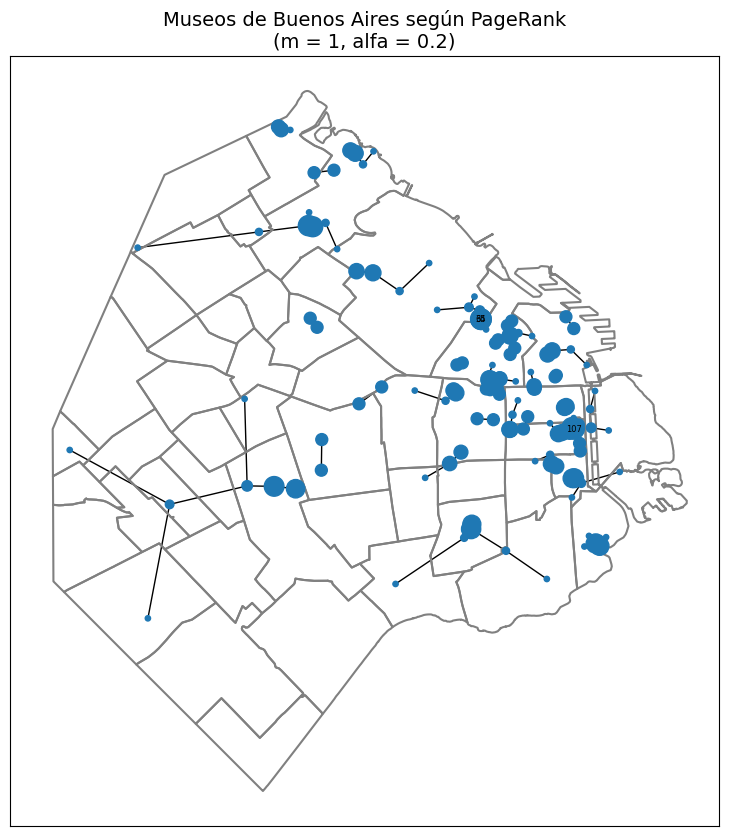

Los museos principales son:
Museo Nacional de Arte Decorativo
Museo del antiguo recinto del Congreso Nacional
Museo Nacional de Arte Oriental



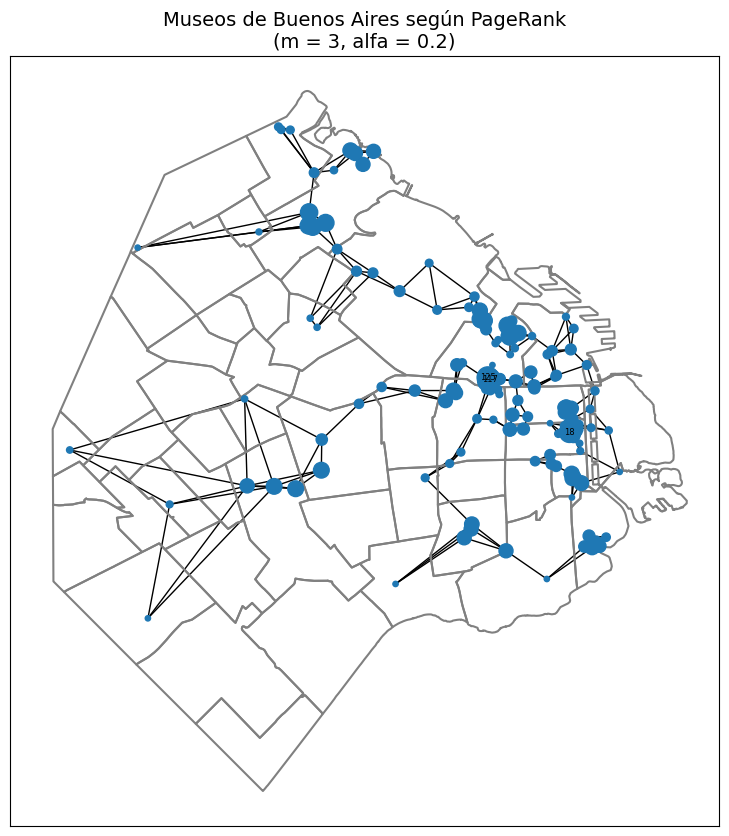

Los museos principales son:
Museo de la Ciudad
Museo de la Facultad de Odontología
Museo de Farmacobotánica



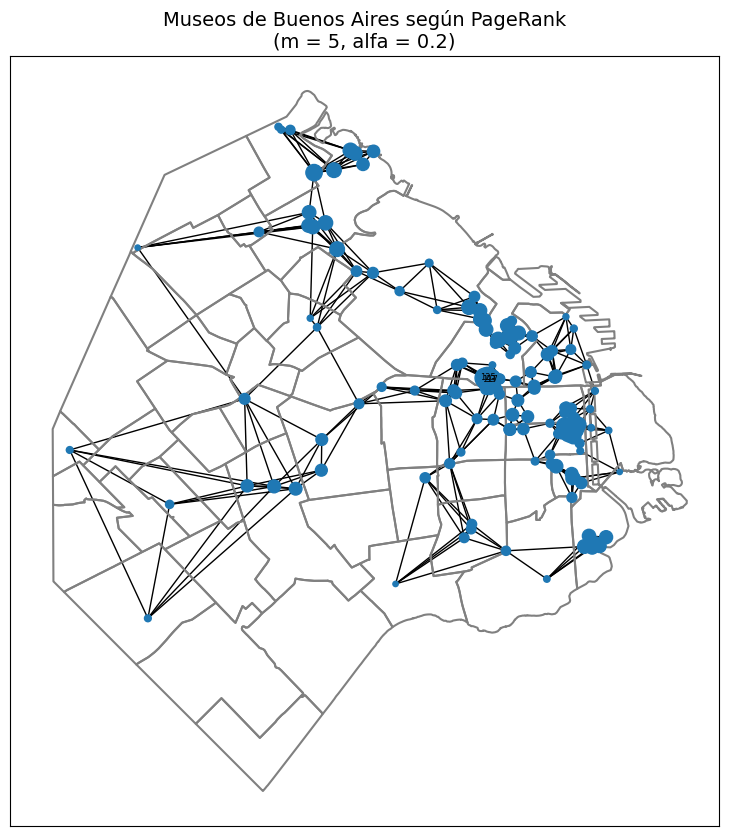

Los museos principales son:
Museo de Farmacobotánica
Museo de la Facultad de Odontología
Museo de Odontología



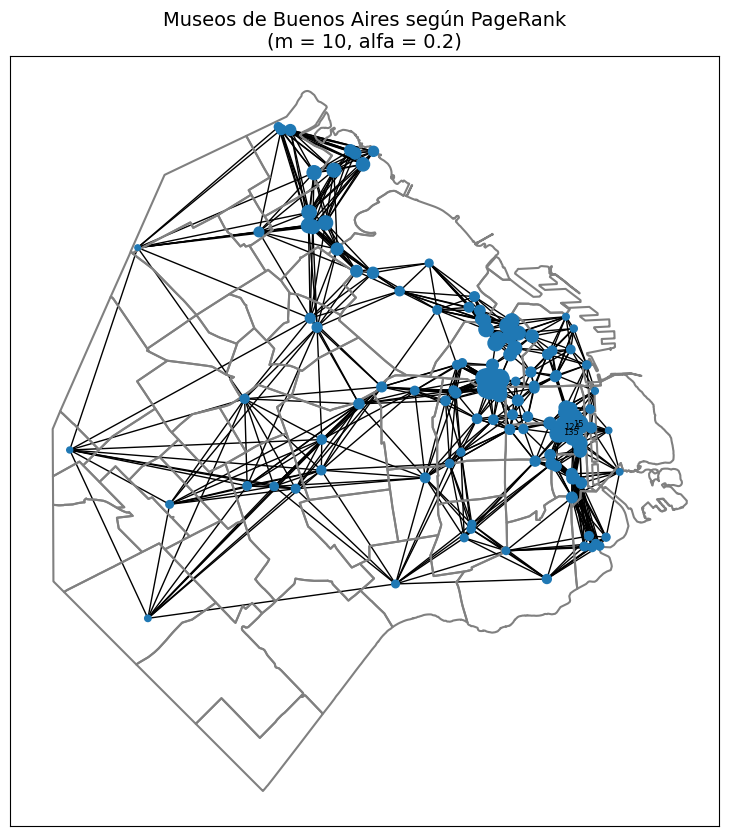

Los museos principales son:
Museo Casa Rosada
Museo Franciscano
Museo Histórico de la AFIP



In [38]:
for m in [1, 3, 5, 10]:
    graficarRedPesandoPageRank(D, m, 1/5)

Obsevemos que como va cambiando el pagerank de los museos principales al cambiar el m.

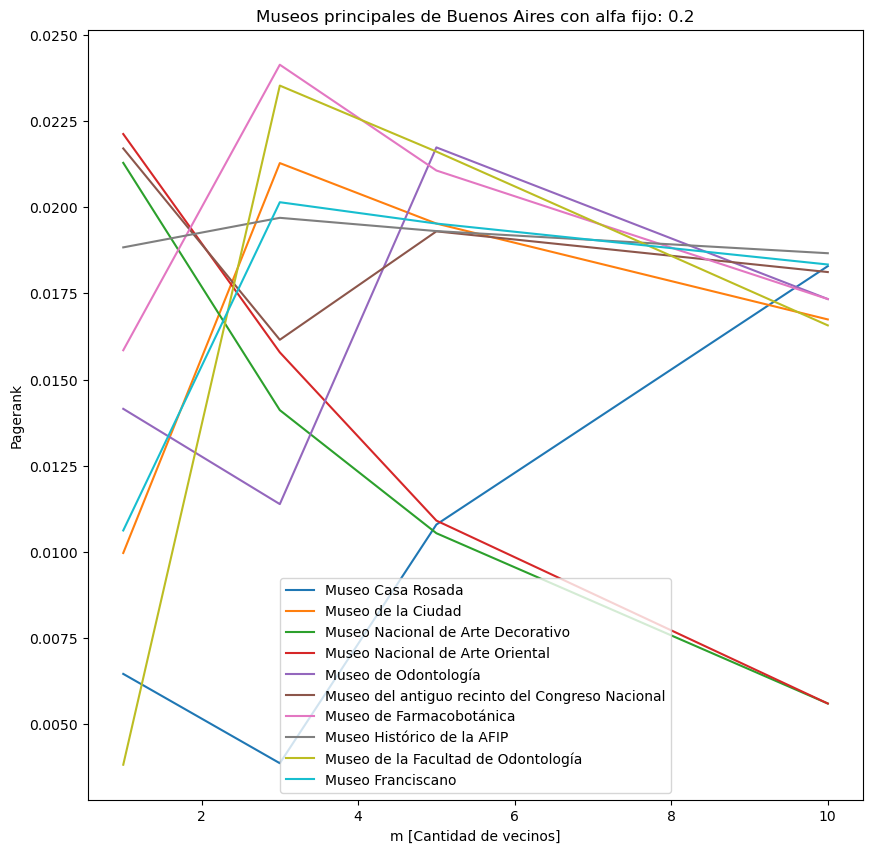

In [39]:
ms = [1, 3, 5, 10]
lista_m = np.array([1, 3, 5, 10])
alfa = 1/5
principalesAlphaFijo(D, lista_m, alfa)

### Observemos que sucede si dejamos fijo el m en 5, y vamos modificando el alfa.

Miremos como va cambiando la red de museos y van cambiando sus PageRank a medida que cambiamos el alfa.

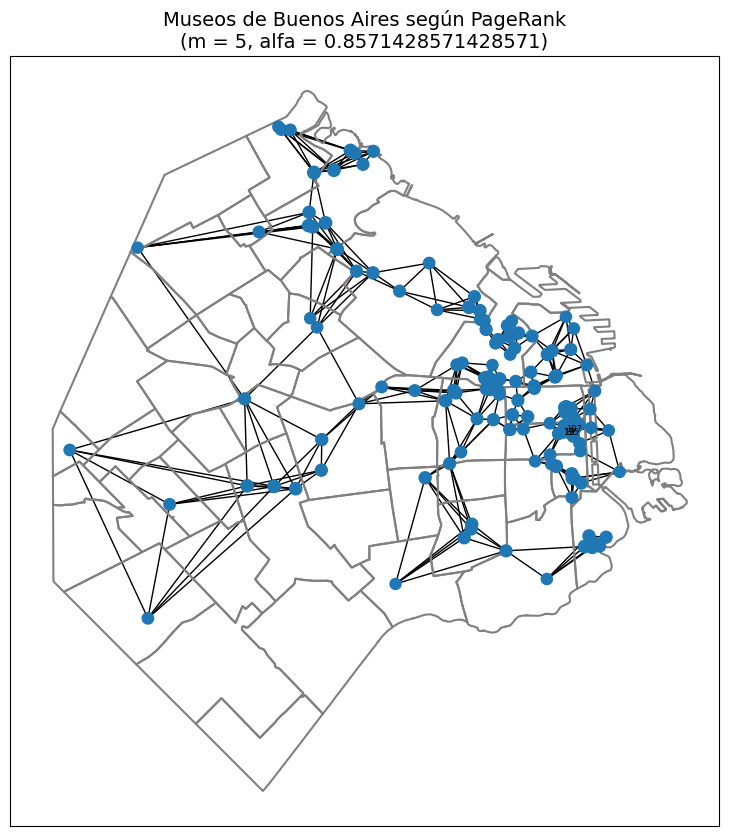

Los museos principales son:
Museo de la Ciudad
Museo Franciscano
Museo del antiguo recinto del Congreso Nacional



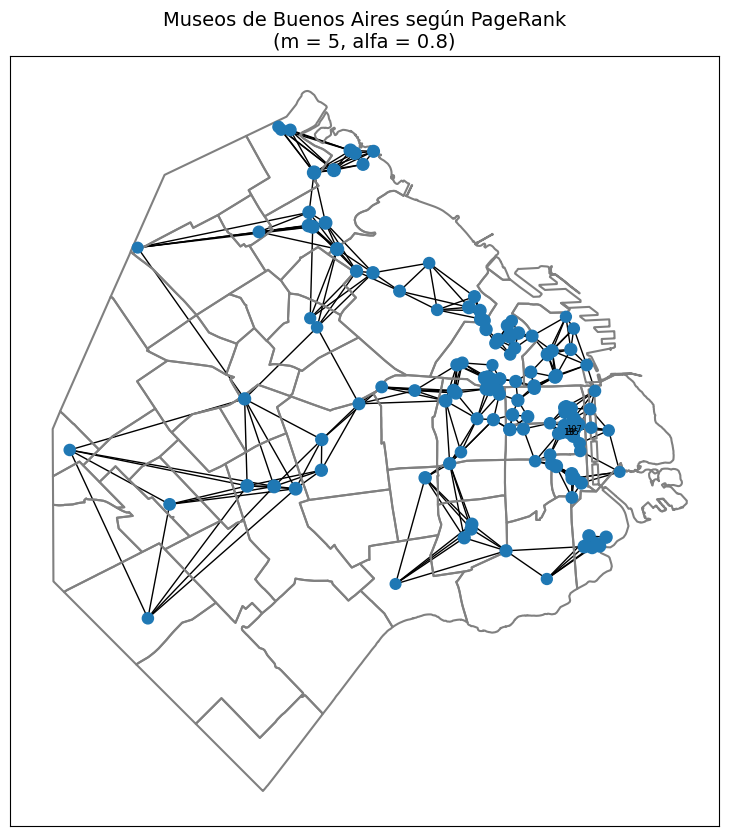

Los museos principales son:
Museo de la Ciudad
Museo Franciscano
Museo del antiguo recinto del Congreso Nacional



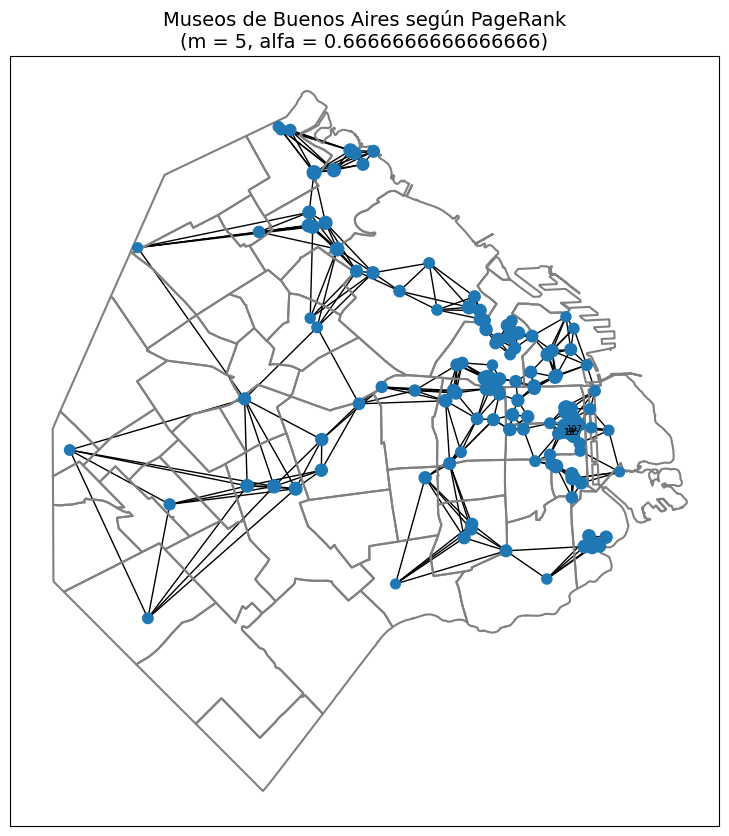

Los museos principales son:
Museo de la Ciudad
Museo Franciscano
Museo del antiguo recinto del Congreso Nacional



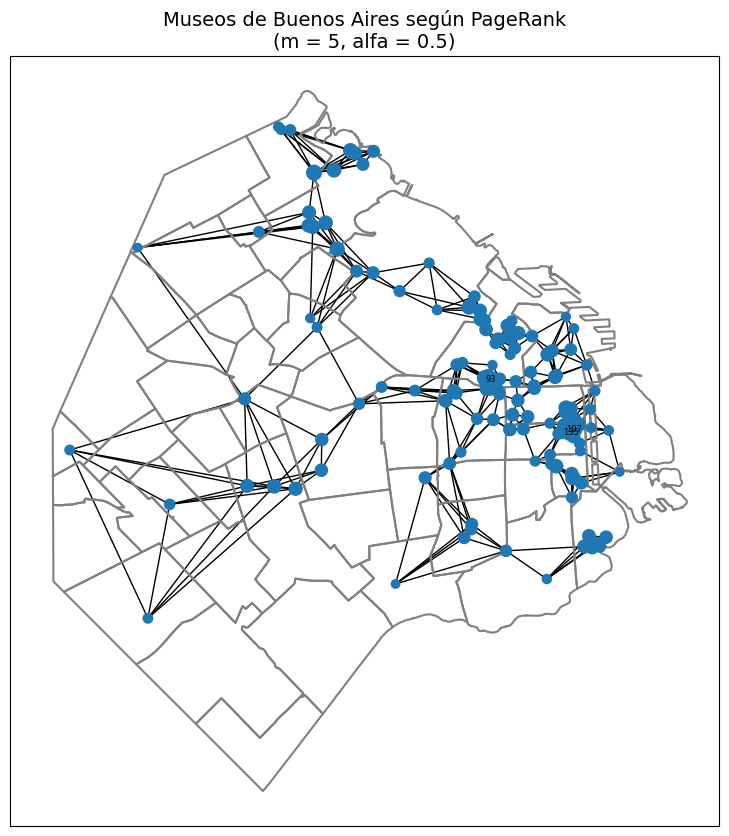

Los museos principales son:
Museo Franciscano
Museo de Odontología
Museo del antiguo recinto del Congreso Nacional



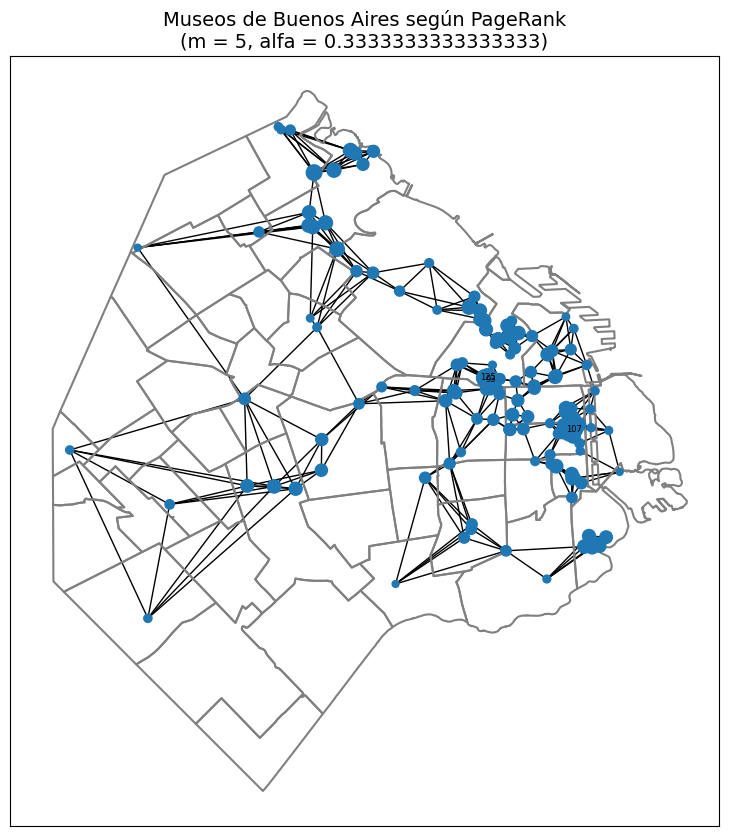

Los museos principales son:
Museo del antiguo recinto del Congreso Nacional
Museo de la Facultad de Odontología
Museo de Odontología



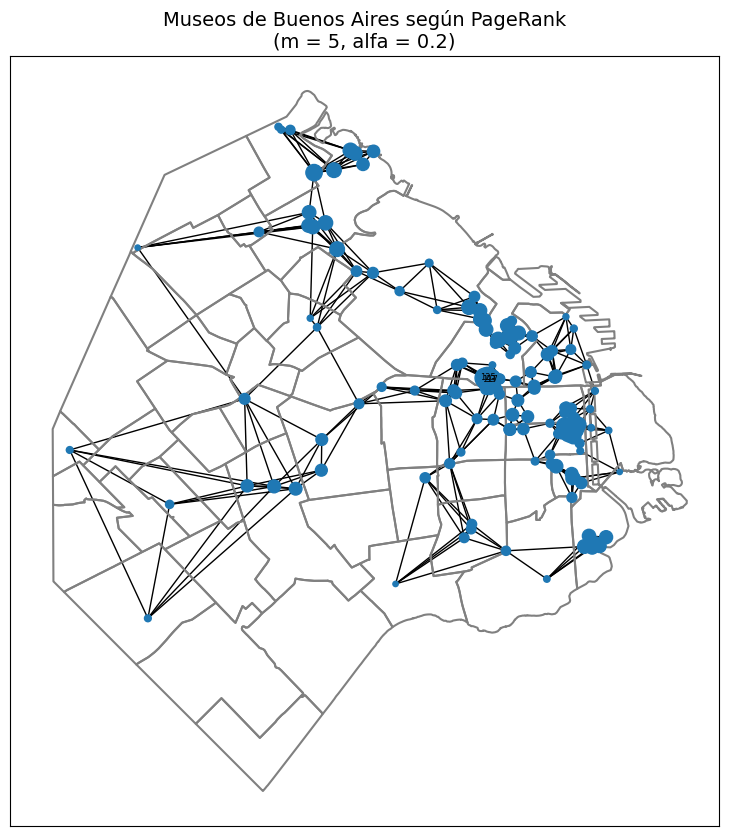

Los museos principales son:
Museo de Farmacobotánica
Museo de la Facultad de Odontología
Museo de Odontología



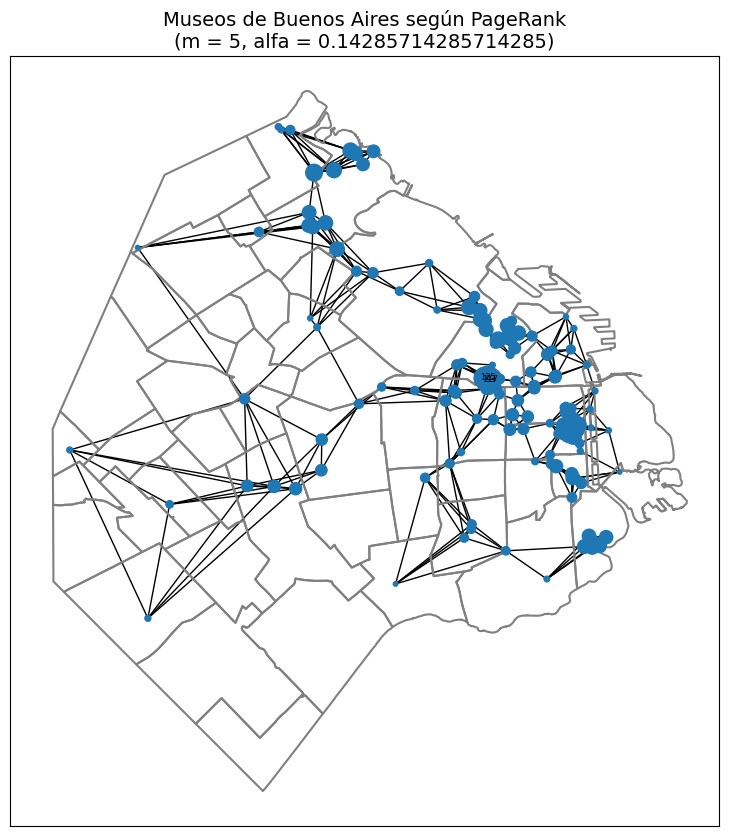

Los museos principales son:
Museo de Farmacobotánica
Museo de la Facultad de Odontología
Museo de Odontología



In [48]:
for alfa in [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]:
    graficarRedPesandoPageRank(D, 5, alfa)

Obsevemos que como va cambiando el pagerank de los museos principales al cambiar el m.

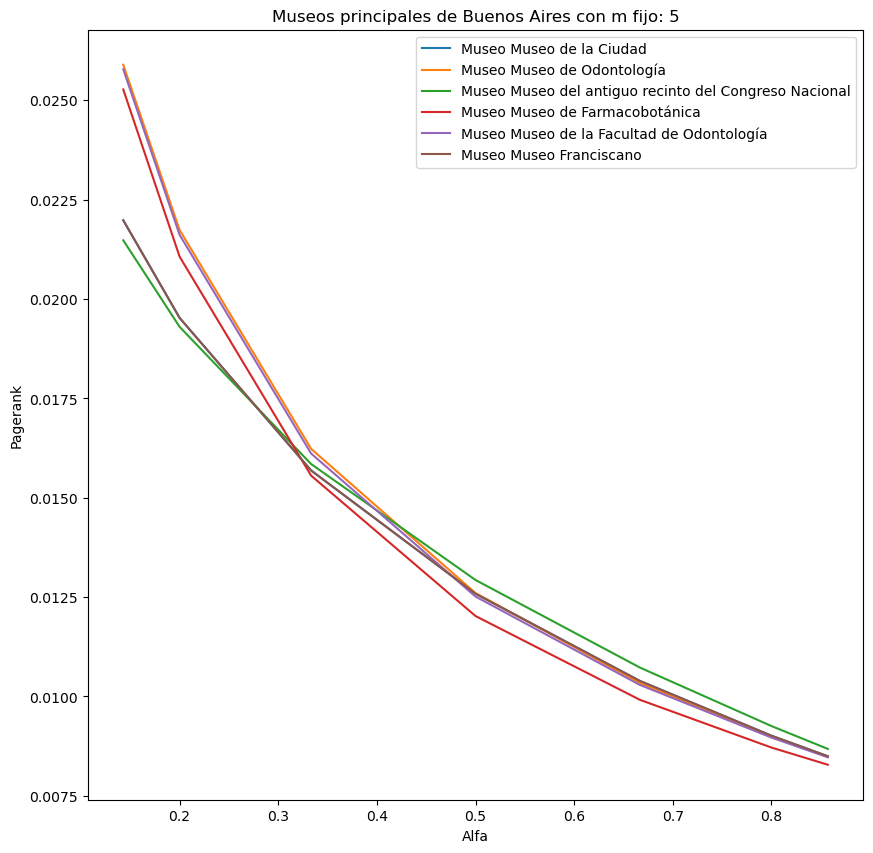

In [41]:
lista_alpha = np.array([1/7, 1/5, 1/3, 1/2, 2/3, 4/5, 6/7])
m = 5

principalesMFijo(D, lista_alpha, m)

### Respuestas a la preguntas:

a) Las posiciones en el ranking no son del todo estables. Si no que, notamos que mientras más aumenta "m", la cantidad de vecinos, los museos que se encuentran en el centro van tomando más protagonismo en el ranking, por lo que se ven favorecidos por el aumento de dicha variable.
En redes con pocas conexiones, hay otros museos en el ranking, aquellos que son centrales, pero no del todo, sin embargo, no son los de la periferia, esos se mantienen segregados para los valores de "m" graficados.  

b) Como ya fue mencionado, las regiones centrales se vuelven más predominantes al aumentar el "m". Mientras que, al aumentar el $\alpha$, lo que sucede es que hay más posibilidad de "Caminatas aleatorias", lo cual genera un beneficio uniforme entre todos los museos.

## Punto 4:

Sea $v :=$ Vector que tiene en su componente $v_i$ el número de personas que tuvo el museo $i$ como punto de entrada a la red.

Sea $w :=$ Vector que tiene en su componente $w_i$ el número total de visitas que recibio el museo $i$.

Sea $B := \sum_{k=0}^{r-1} (C^{k})$

Queremos ver que podemos estimar el valor de $v$ como:

$v = B^{-1}w$

$\space$

Veamos:

$v = B^{-1}w$

$\iff$ (Por B inversible)

$B v = w$

$\iff$ (Por Def de B)

$\sum_{k=0}^{r-1} (C^{k}) v = w$

$\iff$

$\sum_{k=0}^{r-1} (C^{k}v) = w$

$\space$

Es decir,

$(C^{0}v + C^{1}v + … + C^{r-1}v) = w$

$(C^{k})_{ji}$ nos dice la probabilidad de que una persona que empieza en el museo $i$, luego de $k$ pasos termine en el museo $j$.

Notemos que si $v$ es el número de visitantes que entraron a la red en cada museo, entonces luego de $k$ pasos podemos esperar la distribución $C^{k}v$ sobre el total de museos.

$C^{0}v$ estima donde van a estar los visitantes en el paso $0$.

$C^{1}v$ estima donde van a estar los visitantes en el paso $1$.

...

$C^{r-1}v$ estima donde van a estar los visitantes en el paso $r-1$.

Por lo tanto, su sumatoría nos va a decir la cantidad **total** estimada de visitantes que recibio cada museo luego de que cada visitante dé $r$ pasos, es decir la definición de nuestro $w$.

## Punto 5:

In [42]:
C = calcula_matriz_C_continua(D)

B = calcula_B(C, 3)

# w : = vector numero total de visitantes de cada museo.
w = np.loadtxt('visitas.txt')

L, U = calculaLU(B)

# Bv = w
# LUv = w

# Ly = w
# Uv = y

y = scipy.linalg.solve_triangular(L,w,lower=True)  # Ly=w
v = scipy.linalg.solve_triangular(U,y)  # Uv = y

print("Cantidad total de visitantes que entraron en la red (Norma 1 de v): ", norma_1(v))

Cantidad total de visitantes que entraron en la red (Norma 1 de v):  136605.0


/home/malaino/Documents/uba/alc/tp2/template_funciones.py:91: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


## Punto 6:

In [43]:
#C = calcula_matriz_C_continua(D)  # Puedo mantener comentadas estas dos lineas porque ya calculamos C y B en el punto 5.
#B = calcula_B(C, 3)
## Ya tenemos B calculada.

# Busquemos Binv.

# BX = I
# LUX = I

# LY = I
# UX = Y

n, m = B.shape
I = np.eye(n)

Y = scipy.linalg.solve_triangular(L,I,lower=True)  # LY = I
Binv = scipy.linalg.solve_triangular(U,Y)  # UX = Y

numero_condicion_B = norma_1(B) * norma_1(Binv)

print("Número de condición de B: ", numero_condicion_B)

print("Cota error: ", numero_condicion_B * 0.05)

Número de condición de B:  5.051771176665004
Cota error:  0.2525885588332502


# PARTE 2:

## Punto 1:

## Punto 2:

Sea una matriz $M \in \mathbb{R}^{n \times n}$ diagonalizable, con autovalores $\lambda_1 \ge \lambda_2 \ge ... \ge \lambda_n$, y sea $v_i$ un autovector asociado al autovalor $\lambda_i$.

### Item a:

- Queremos demostrar que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$, y que el autovalor asociado a $\gamma_i$ es $v_i$.

Como $v_i$ es el autovector de $M$ asociado a $\lambda_i$, por definición se cumple que $Mv_i = \lambda_iv_i$, siendo $v_i$ no nulo.

Queremos ver que $(M+\mu I)v_i = (\lambda_i+\mu)v_i$.

Desarollando el lado izquierdo de la igualdad:
$(M+\mu I)v_i = Mv_i+\mu Iv_i = Mv_i+\mu v_i = \lambda_i v_i + \mu v_i = (\lambda_i+\mu)v_i$

Por lo tanto $v_i$ también es un autovector de $M + \mu I$, y su autovalor asociado es $\gamma_i$ es $v_i$ como queríamos probar.

- Veamos que si $\mu + \lambda_i \not = 0$ $\forall i$, entonces $M + \mu I$ es inversible.

Como $\mu + \lambda_i$ son los autovalores de la matriz $M + \mu I$, si cada $\mu + \lambda_i$ es distinto de cero, entonces todos los autovalores de $M + \mu I$ serán no nulos. Por lo tanto, es inversible.

### Item b:

Antes de resolver el item, demostremos un teorema intermedio que nos va a ser de utilidad.

#### (2.1) Teorema:

Si $A \in \mathbb{C}^{n \times n}$ ($A \in \mathbb{R}^{n \times n}$) es semi definida positiva, entonces todos sus autovalores son reales y son no negativos.

##### Demostración:
1) Veamos que sus autovalores son reales:

Como $A$ es semi definida positiva, por definición sabemos que es hermitiana. Luego como es hermitiana sus autovalores son reales.

2) Veamos que sus autovalores son no negativos:
 
Como $A$ es semi definida positiva, por definición tenemos que $v^*Av \ge 0$ $\forall v$.

Sea $v$ un autovector de $A$ y $\lambda$ su autovalor asociado.
$Av = \lambda v$ $\iff$ $v^*Av = \lambda v^* v$

$v^*Av \ge 0$ por definición de semi definida positiva.

$v^*v \ge 0$ por propiedad del producto interno.

Separemos en casos según el valor de $v^*v$:

Si $v^*v = 0$ $\iff$ $v=0$, el vector nulo sería un autovector. ABSURDO! Por definición, el vector nulo no puede ser un autovector.

Si $v^*v \not = 0$ entonces $v^*v > 0$ y por lo tanto, para que se cumpla la igualdad $v^*Av = \lambda v^* v$, es necesario que $\lambda \ge 0$.

#### (2.2) Lema:

Si $M$ es una matriz inversible, y $v$ es un autovector de $M$ con autovalor $\lambda$, entonces $M^{-1}$ tiene como autovector a $v$ con autovalor $\frac{1}{\lambda}$.

##### Demostración:
Sea $v$ un autovector de $M$ con autovalor $\lambda$, por definición tenemos que $Mv = \lambda v$ $\iff$ $v = \lambda M^{-1} v$ $\iff$ $M^{-1}v=\frac{1}{\lambda}v$

Luego $M^{-1}$ tiene a $v$ como autovector con autovalor $\frac{1}{\lambda}$.

------------------------------------------------------

- Considerando $\mu > 0$, queremos ver que $L + \mu I$ es inversible.

Llamemos $\lambda_1, ..., \lambda_n$ los autovalores de $L$. Con $\lambda_1 \ge ... \ge \lambda_n$

Por el enunciado, sabemos que la matriz $L \in \mathbb{R}^{n \times n}$ es semidefinida positiva. Al cumplir las hipotesis del teorema (2.1), tenemos que todos sus autovalores $\lambda_i \ge 0$.

Luego como $L$ es simetrica, por corolario del teorema espectral tenemos que $L$ es diagonalizable.
Por lo tanto, usando el punto (2.a), si $v_i$ es un autovector de $L$ asociado al autovalor $\lambda_i$, $v_i$ es un autovector de $L + \mu I$ asociado al autovalor $\lambda_i + \mu$.

Como $\mu > 0$ por hipotesis y además $\lambda_i \ge 0$. Podemos concluir que $\lambda_i + \mu > 0$.

Por lo tanto, por la conclusión del punto (2.a), $L + \mu I$ es inversible.

- Veamos que aplicar el método de la potencia a $(L + \mu I) ^{-1}$ converge a su autovector de autovalor más chico si se parte de una semilla adecuada.

Como $L + \mu I$ es inversible y tiene autovalores de la forma $\lambda_i + \mu$, los autovalores de $(L + \mu I)^{-1}$ son de la forma $\frac{1}{\lambda_i + \mu}$ por lema (2.2).

Del orden de los autovalores de $L$ podemos obtener información del orden de los autovalores de $(L + \mu I)^{-1}$:

$\lambda_1 \ge ... \ge \lambda_n$
$\iff$
$\lambda_1 + \mu \ge ... \ge \lambda_n + \mu$
$\iff$
$\frac{1}{\lambda_1 + \mu} \le ... \le \frac{1}{\lambda_n + \mu}$

Tenemos que el autovalor dominante de $(L + \mu I)^{-1}$ es $\frac{1}{\lambda_n + \mu}$, luego $\lambda_n + \mu$ es el autovalor más pequeño de $L + \mu$ y se sigue que $\lambda_n$ es el autovalor más pequeño de $L$.

Si aplicamos el método de la potencia a $(L + \mu I)^{-1}$, obtendremos un vector del autoespacio del autovalor $\frac{1}{\lambda_n + \mu}$, pero como vimos, ese vector va a estar también en el autoespacio del autovalor de $\lambda_n + \mu$ en $L +\mu$ y en el autoespacio del autovalor $\lambda_n$ en $L$.

Por lo tanto, vemos que aplicar el método de la potencia a $(L + \mu I)^{-1}$ converge a un autovector de $L$ con autovalor más chico.

TODO: AGREGAR CONDICIÓN PARA QUE LA SEMILLA SEA ADECUADA!!!!

- Indiquemos, en el caso de que hay sólo un autovector con dicho autovalor, cuál es dicho autovector y cuánto vale su autovalor.

Recordemos del punto (1.a) que $L$ tiene como autovector a $\textbf{1}$ con autovalor asociado $0$. y además vimos que todos los autovalores de $L$ son $\ge 0$, por lo tanto, $\lambda_n = 0$.

Luego el autovalor dominante de $(L + \mu)^{-1}$ es $\frac{1}{\lambda_n + \mu} = \frac{1}{\mu}$ y además tiene como autovector a $\textbf{1}$.

Como nos garantizan que hay un solo autovector con dicho autovalor, la multiplicidad del autovalor es uno. Por lo tanto, el método de la potencia va a converger a un multiplo del autovector $\textbf{1}$, a $\frac{\textbf{1}}{\|\textbf{1}\|}$, el vector normalizado.

En conclusión, si $L$ tiene un único autovalor mínimo, ese autovalor es $0$ y el autovector al cual va a converger, en caso de que la semilla sea adecuada, es $\frac{\textbf{1}}{\|\textbf{1}\|}$.


### Item c:

- Suponiendo de que $M$ es simétrica (y por lo tanto admite una base ortogonal de autovectores), queremos mostrar que la matriz $\tilde{M} := M - \lambda_1 \frac{v_1 v_1^t} {v_1^t v_1}$ tiene los mismos autovalores que $M$, pero el autovalor asociado a $v_1$ es igual a cero.

Para ello veamos que:
1) $\tilde{M}v_1 = 0 v_1 = \vec{0}$
2) $\tilde{M}v_i = \lambda_i v_i$ con $i \not = 1$

Veamos 1:

$\tilde{M}v_1 = (M - \lambda_1 \frac{v_1 v_1^t} {v_1^t v_1}) v_1 = Mv_1 - \lambda_1 \frac{v_1 v_1^t v_1} {v_1^t v_1} = Mv_1 - \lambda_1 v_1$

Como $v_1$ es un autovector de $M$ asociado al autovalor $\lambda_1$, $Mv_1 = \lambda_1 v_1$ 

$ Mv_1 - \lambda_1 v_1 = \lambda_1 v_1 - \lambda_1 v_1 = \vec{0}$

Por lo tanto $\tilde{M}v_1 = 0 v_1$.

Veamos 2:

Recordemos que como $M$ admite una base ortogonal de autovectores, si $v_i$ y $v_j$ son autovectores, y $i \not = j$ entonces $v_i^t v_j = 0$

CONSULTAR SI PUEDO ASUMIR QUE M ES UNA MATRIZ REAL!!!! AGREGAR QUE SUS AUTOVALORES SON REALES.

Sea $i \not = 1$:

$\tilde{M}v_i = (M - \lambda_1 \frac{v_1 v_1^t} {v_1^t v_1}) v_i = Mv_i - \lambda_1 \frac{v_1 v_1^t v_i} {v_1^t v_1}$

Como $v_1^t v_i = 0$ y $v_i$ es un autovector de $M$ asociado al autovalor $\lambda_i$, $Mv_i = \lambda_i v_i$, tenemos que:

$Mv_i - \lambda_1 \frac{v_1 0} {v_1^t v_1} = \lambda_i v_i - \lambda_1 \frac{\vec{0}} {v_1^t v_1} = \lambda_i v_i - \vec{0} = \lambda_i v_i$

Por lo tanto $\tilde{M}v_i = \lambda_i v_i$ si $i \not = 1$.

Queda demostrada la propiedad que queriamos ver sobre $\tilde{M}$.

## Punto 4:

In [106]:
COLORES = [
    'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow',
    'brown', 'lime', 'pink', 'olive', 'teal', 'gold', 'gray', 'navy', 'darkred',
    'darkgreen', 'deepskyblue', 'indigo'
]

def graficarPoblaciones(D, m_mas_cercanos, conLabels=True):
    # Grafica la red de museos asignando a cada museo una población.
    # Parametros: matriz D, m_mas_cercanos, conLabels (opcional).
    
    # D: Matriz de distancias.
    # m_mas_cercanos: Parametro para armar la matriz de adyacencia.
    # conLabels: Indica si en el gráfico, a cada nodo de museo, si le debe agregar una label indicando a que población pertenece.
    #            museos con la misma label corresponden a museos de la misma población.

    A = construye_adyacencia(D, m) # Obtenemos la matriz de adyacencia que une a los museos con sus m más cercanos.
    A_prima = np.ceil(1/2 * (A + A.T)) # Simetrizamos la matriz de adyacencia.
    lista_poblaciones = modularidad_iterativo(A_prima) # Calculamos la división de sus poblaciones.
    
    # Construir el grafo
    G = nx.from_numpy_array(A)
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    # Warning sobre si la cantidad de colores es adecuada en relación a la cantidad de poblaciones:
    if(len(COLORES) < len(lista_poblaciones)):
        print(
            "WARNING: Hay más poblaciones que colores disponibles.\n"
            "En el gráfico van a aparecer museos que coinciden en color pero que pertenecen a poblaciones distintas.\n"
            "Aunque se pueden diferenciar por su label, se recomienda extender la lista de 'COLORES' para una mejor visualización."
        )

    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax) # Graficamos Los barrios

    # Dibujamos los nodos de los museos con sus respectivos colores.
    for i, poblacion in enumerate(lista_poblaciones):
        color = COLORES[i % len(COLORES)]
        nx.draw_networkx_nodes(G, G_layout, nodelist=poblacion, node_color=color, node_size=100, ax=ax)
    
    nx.draw_networkx_edges(G, G_layout, ax=ax, alpha=0.4)
    
    # Labels:
    if(conLabels):
        # A cada museo le asignamos su población correspondiente para crear las labels.
        museo_a_poblacion = {}
        for i, poblacion in enumerate(lista_poblaciones):
            for museo in poblacion:
                museo_a_poblacion[museo] = i
        
        # Asignamos las labels de los museos representando a que población corresponde.
        # El número de label es arbitrario pero museos con la misma label pertenecen a la misma población.
        labels = {n: str(museo_a_poblacion[n]) for n in G.nodes if n in museo_a_poblacion}

        # Agregamos en el gráfico las labels.
        nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="black", ax=ax)

    
    plt.title(f"Red de Museos separada en poblaciones usando modularidad (m = {m})")
    plt.axis('off')
    plt.show()
    

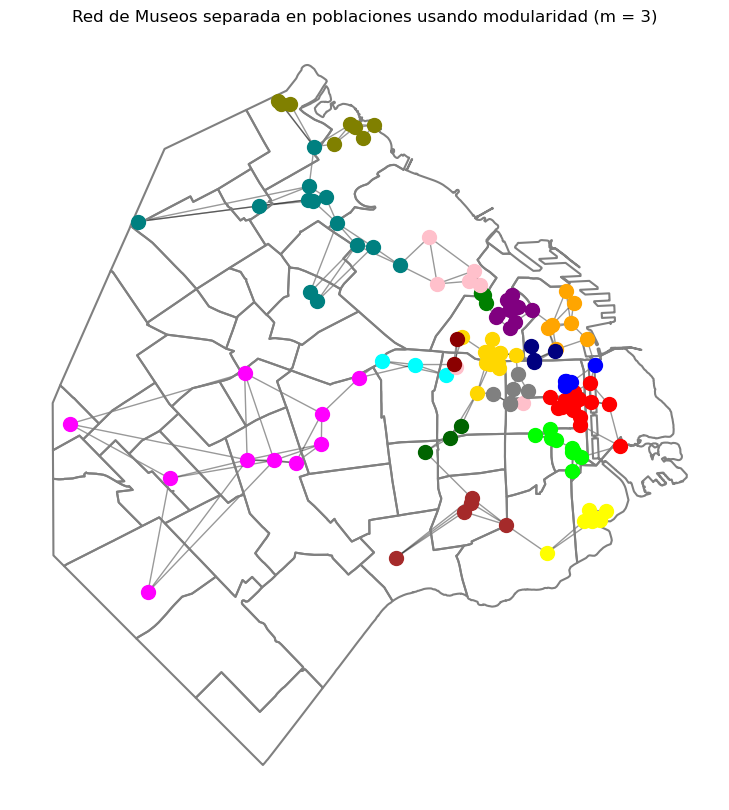

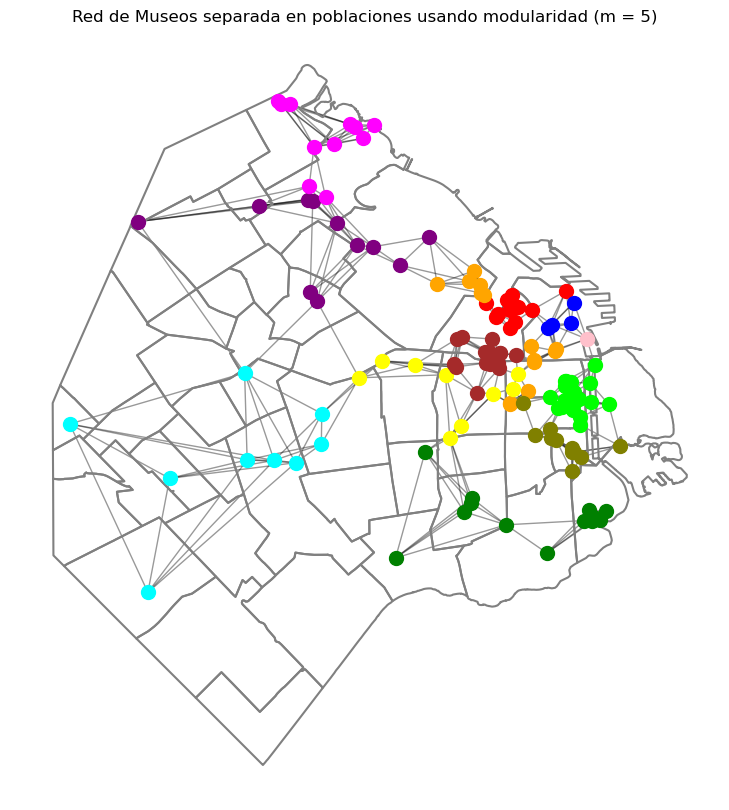

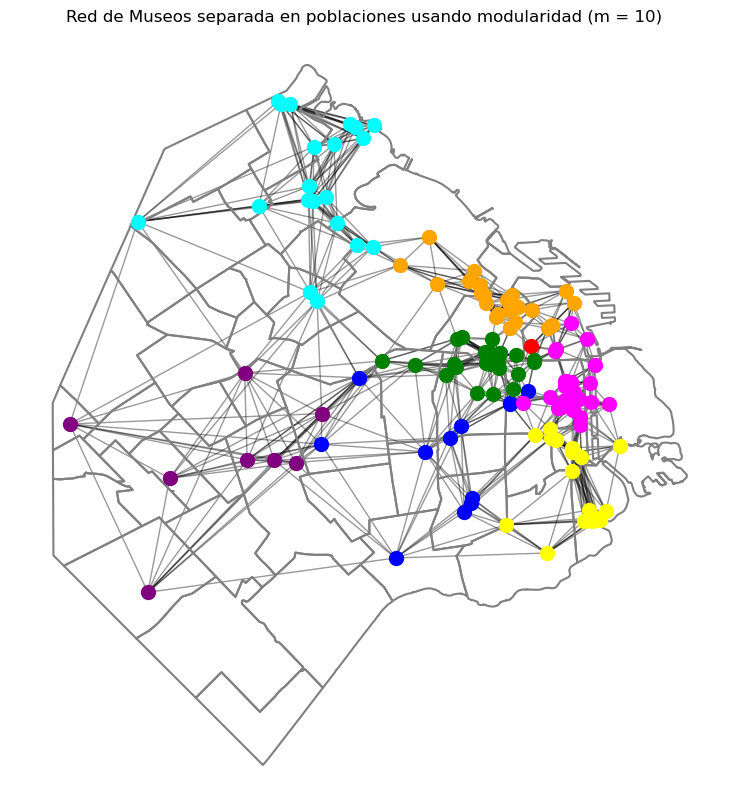

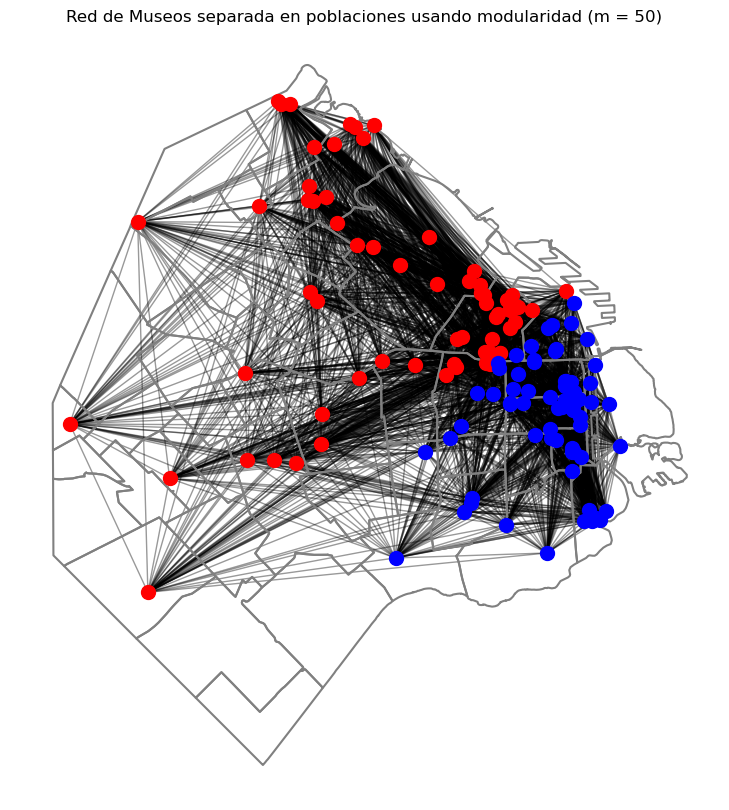

In [107]:
ms = [3, 5, 10, 50]

for m in ms:
    # Graficamos las poblaciones. Los museos que comparte label y color pertenecen a la misma población.
    graficarPoblaciones(D, m, conLabels=False)

    #for i in range(len(lista_poblaciones)):
    #    print(f"{i}: {lista_poblaciones[i]}")
    #print("----------")

In [108]:
COLORES = [
    'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow',
    'brown', 'lime', 'pink', 'olive', 'teal', 'gold', 'gray', 'navy', 'darkred',
    'darkgreen', 'deepskyblue', 'indigo'
]

def graficarPoblacionesModularidad(D, m, conLabels=True, ax=None):
    # Construir la matriz de adyacencia y particionar por modularidad
    A = construye_adyacencia(D, m) # Obtenemos la matriz de adyacencia que une a los museos con sus m más cercanos.
    A_prima = np.ceil(1/2 * (A + A.T))  # Simetrizamos
    # Obtenemos la lista de poblaciones usando el método de modularidad iterativo.
    lista_poblaciones = modularidad_iterativo(A_prima)
    # Graficamos.
    graficarPoblaciones(A, m, lista_poblaciones, conLabels, ax)

def graficarPoblacionesLaplaciano(D, m, cantidad_niveles, conLabels=True, ax=None):
    # Construir la matriz de adyacencia y particionar por modularidad
    A = construye_adyacencia(D, m) # Obtenemos la matriz de adyacencia que une a los museos con sus m más cercanos.
    A_prima = np.ceil(1/2 * (A + A.T))  # Simetrizamos
    # Obtenemos la lista de poblaciones usando el método laplaciano iterativo.
    lista_poblaciones = laplaciano_iterativo(A_prima, cantidad_niveles)
    # Graficamos.
    graficarPoblaciones(A, m, lista_poblaciones, conLabels, ax)

def graficarPoblaciones(A, m, lista_poblaciones, conLabels=True, ax=None):
    # Warning si hay más poblaciones que colores
    if len(COLORES) < len(lista_poblaciones):
        print(
            "WARNING: Hay más poblaciones que colores disponibles.\n"
            "En el gráfico van a aparecer museos que coinciden en color pero que pertenecen a poblaciones distintas.\n"
            "Aunque se pueden diferenciar por su label, se recomienda extender la lista de 'COLORES' para una mejor visualización."
        )

    # Construir el grafo
    G = nx.from_numpy_array(A)
    G_layout = {i: (x, y) for i, (x, y) in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'], museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    # Usar ax dado o crear uno nuevo si no se pasa
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax) # Graficamos Los barrios

    # Dibujar nodos por población
    for i, poblacion in enumerate(lista_poblaciones):
        color = COLORES[i % len(COLORES)]
        nx.draw_networkx_nodes(G, G_layout, nodelist=poblacion, node_color=color, node_size=100, ax=ax)

    nx.draw_networkx_edges(G, G_layout, ax=ax, alpha=0.4)

    # Dibujar labels con número de población
    if conLabels:
        museo_a_poblacion = {museo: i for i, poblacion in enumerate(lista_poblaciones) for museo in poblacion}
        labels = {n: str(museo_a_poblacion[n]) for n in G.nodes if n in museo_a_poblacion}
        nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="black", ax=ax)

    # Título con m y cantidad de poblaciones
    cantidad_poblaciones = len(lista_poblaciones)
    ax.set_title(f"m = {m}  |  {cantidad_poblaciones} poblaciones detectadas")
    ax.axis('off')


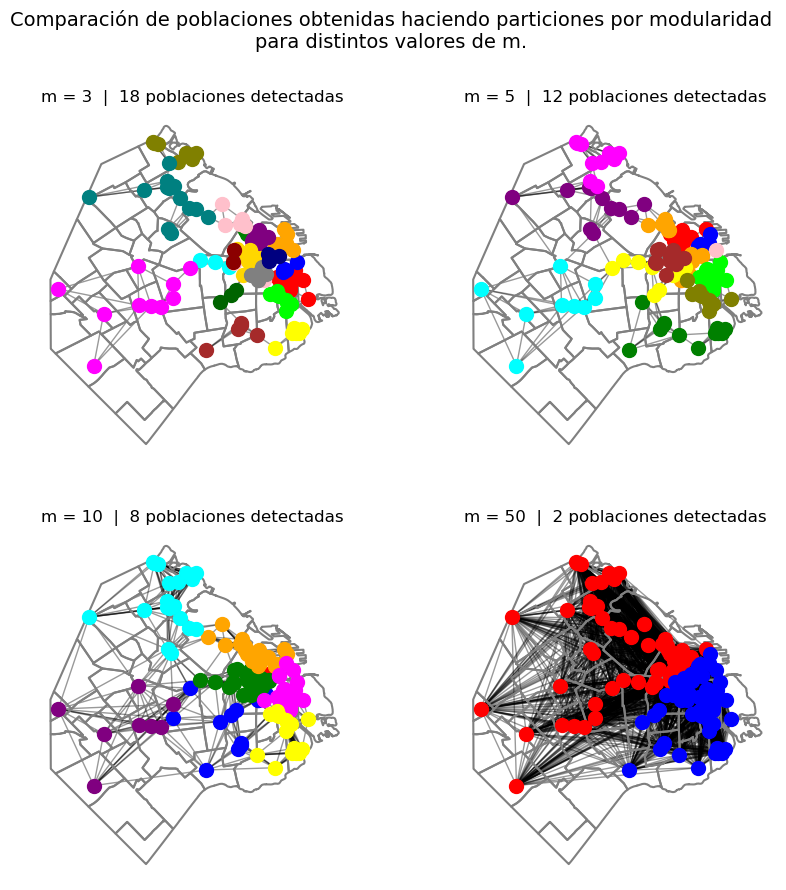

In [109]:
ms = [3, 5, 10, 50]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 filas x 2 columnas
axes = axes.flatten()

for i, m in enumerate(ms):
    graficarPoblacionesModularidad(D, m, conLabels=False, ax=axes[i])

plt.suptitle("Comparación de poblaciones obtenidas haciendo particiones por modularidad\npara distintos valores de m.", fontsize=14)
plt.show()

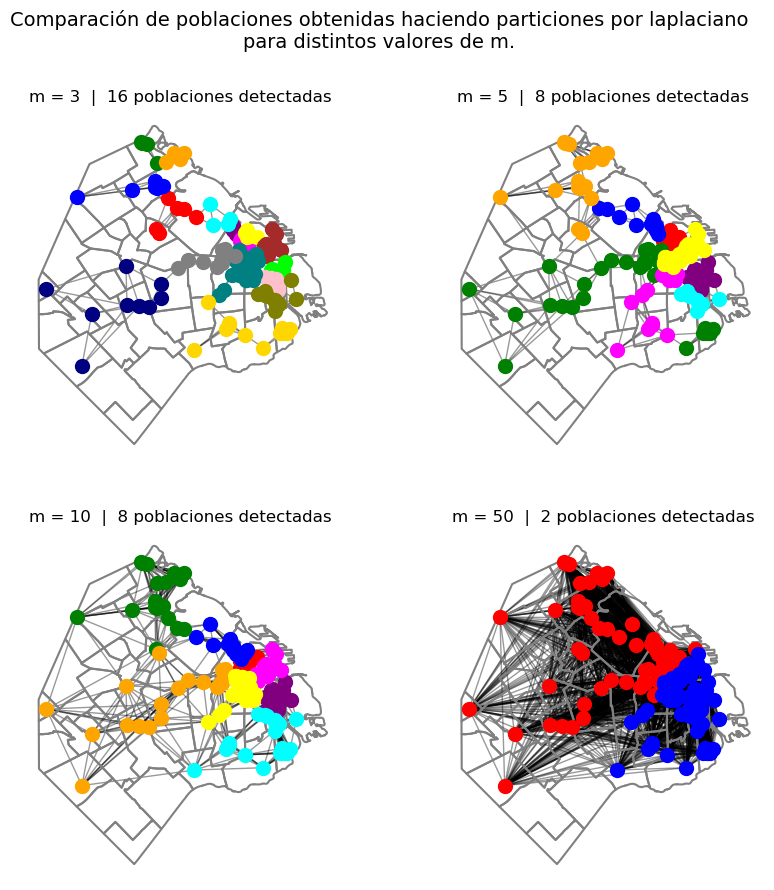

In [105]:
ms = [3, 5, 10, 50]
numero_de_cortes = [4, 3, 3, 1] # Elejidos para que se asemejen a la cantidad de poblaciones detectadas por el método de la modularidad.

fig, axes = plt.subplots(2, 2, figsize=(10, 10)) # 2 filas x 2 columnas
axes = axes.flatten()

for i, m in enumerate(ms):
    graficarPoblacionesLaplaciano(D, m, numero_de_cortes[i], conLabels=False, ax=axes[i])

plt.suptitle("Comparación de poblaciones obtenidas haciendo particiones por laplaciano\npara distintos valores de m.", fontsize=14)
plt.show()